In [44]:
%matplotlib inline

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import copy
import time

from multi_rake import Rake

# Load the diabetes dataset
import os
print(os.listdir("./data"))

['Hotel_Reviews.csv']


In [46]:
reviewsRawData = pd.read_csv("./data/Hotel_Reviews.csv", usecols=['Positive_Review', 'Negative_Review', 'Reviewer_Score'])

In [47]:
# to make sure there's no empty attribute
reviewsRawData.count()

Negative_Review    515738
Positive_Review    515738
Reviewer_Score     515738
dtype: int64

In [48]:
#since there's no empty attribute, we can seperate each column to convert reviews to numberic values
reviewsRawDataPos = reviewsRawData.Positive_Review[:, np.newaxis]
#print(reviewsRawDataPos)
reviewsRawDataNeg = reviewsRawData.Negative_Review[:, np.newaxis]
#reviewsRawDataNeg = reviewsRawData.Negative_Review[0:10, np.newaxis]
reviewerScore = reviewsRawData.Reviewer_Score[:, np.newaxis]
#print(reviewsRawDataPos)
#print()
#print(reviewsRawDataNeg)

In [49]:
rake = Rake()

reviewsNumData = copy.deepcopy(reviewsRawDataPos);

start_time = time.time()

for i in range(0, len(reviewsRawDataPos)):
    reviewsNumData[i][0] = 0
    # get important keywords with weight for each positive review
    posKeywords = rake.apply(reviewsRawDataPos[i][0])
    # each keyword's weight gets added up
    for eachTuple in posKeywords:
        reviewsNumData[i][0]= reviewsNumData[i][0] + eachTuple[1]
    
    # get important keywords with weight for each negative review
    negKeywords = rake.apply(reviewsRawDataNeg[i][0])
    # each keyword's weight gets subtracted
    for eachTuple in negKeywords:
        reviewsNumData[i][0]= reviewsNumData[i][0] - eachTuple[1]

    #print(reviewsNumData[i])
    
print(reviewsNumData[32][0])
print(reviewsRawDataPos[32][0])

# con: due to size of the data, conversion takes time (~5mins)
print("Time taken for conversion: %s minutes " % ((time.time() - start_time)/60))

-44.0
No Positive
Time taken for conversion: 2.7745338042577106 minutes 


In [50]:
# This part was made with referencing Linear regression - OLS vs GD
# Split the data into training/testing sets
reviews_X_train = reviewsNumData[:-100000] # training set = all but last 100000 instances
reviews_X_test = reviewsNumData[-100000:]  #test set = last 100000 instances

# Split the targets into training/testing sets
reviews_Y_train = reviewsScoreData[:-100000]  
reviews_Y_test = reviewsScoreData[-100000:]

Coefficients: 
 [[0.03805247]]
Variance score: 0.21


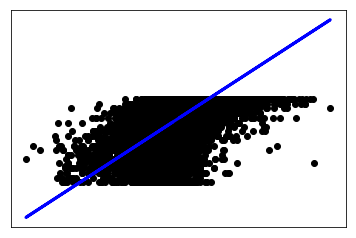

In [53]:
# This part was made with referencing Linear regression - OLS vs GD
# Create linear regression object

regr = linear_model.LinearRegression() #run ordinary least squares

#regr=linear_model.SGDRegressor(loss='squared_loss', alpha=0.01, max_iter=60) #Gradient Descent 

# Train the model using the training sets
regr.fit(reviews_X_train, reviews_Y_train) ##this is where "learning" happens!

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
#print("Mean squared error: %.2f"
#      % np.mean((regr.predict(reviews_X_train) - reviews_Y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(reviews_X_test, reviews_Y_test))

# Plot outputs
plt.scatter(reviews_X_test, reviews_Y_test,  color='black')
plt.plot(reviews_X_test, regr.predict(reviews_X_test), color='blue',
         linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()